# Advanced Data Preparation with Python (Car Data)

## Libraries and settings

In [1]:
# Libraries
import os
import re
import time
import fnmatch
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Get current working directory
print(os.getcwd())

/workspaces/python_exploratory_data_analysis


## Importing data

In [2]:
# Import data from csv to pandas dataframe named 'df'
df = pd.read_csv('./Data/autoscout24_data.csv', sep=";", encoding='utf-8')

# Change the column names to lowercase
df.columns = df.columns.str.lower()

# Display the first 5 rows of the dataframe
df.head()


,url_short,offer_id,scrape_dt,type,price_raw,hp_raw,init_regist,mileage_raw,fuel_type,transmission,dealer_name,dealer_plz,dealer_city,dealer_street_house_nr,dealer_telnr,init_regist_my,init_regist_month,init_regist_year,init_regist_dt
0,https://www.autoscout24.ch/7324420,7324420,2020_03_17 07:34:45,AUDI A5 Sportback 3.0 TDI quattro S-tronic (Li...,CHF 22'500.–,245 PS,10.2014,75'000 km,Diesel,Automatisiertes Schaltgetriebe,***confidential***,8488,Turbenthal,Mettlenstrasse 3,***confidential***,10.2014,10.0,2014.0,2014-10
1,https://www.autoscout24.ch/7512768,7512768,2020_03_17 07:34:55,MERCEDES-BENZ SLK 200 7G-Tronic (Cabriolet),CHF 23'749.–,184 PS,6.2013,46'655 km,Benzin,Automat sequentiell,***confidential***,3186,Düdingen,Brugerastrasse 60,***confidential***,6.2013,6.0,2013.0,2013-06
2,https://www.autoscout24.ch/7512034,7512034,2020_03_17 07:35:03,MERCEDES-BENZ C 350 Avantgarde 4Matic 7G-Troni...,CHF 18'500.–,306 PS,6.2011,138'955 km,Benzin,Automat sequentiell,***confidential***,1262,Eysins,1262 Eysins,***confidential***,6.2011,6.0,2011.0,2011-06
3,https://www.autoscout24.ch/7512728,7512728,2020_03_17 07:35:06,MERCEDES-BENZ A 45 AMG 4Matic Speedshift 7G-DC...,CHF 36'000.–,360 PS,8.2015,43'000 km,Benzin,Automatisiertes Schaltgetriebe,***confidential***,4314,Zeiningen,Am Stutz 21,***confidential***,8.2015,8.0,2015.0,2015-08
4,https://www.autoscout24.ch/7490242,7490242,2020_03_17 07:35:16,AUDI A5 Sportback 2.0 TFSI Sport quattro S-tro...,CHF 48'500.–,252 PS,9.2018,43'300 km,Benzin,Automatisiertes Schaltgetriebe,***confidential***,3250,Lyss,3250 Lyss,***confidential***,9.2018,9.0,2018.0,2018-09


## Count number of rows and columns in the data frame

In [3]:
# Count number of rows and columns in the data frame
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])


Number of rows:  3980
Number of columns:  19


## Get data types (raw-format from web scraper)

In [4]:
# Get data types of each column
df.dtypes


url_short                  object
offer_id                    int64
scrape_dt                  object
type                       object
price_raw                  object
hp_raw                     object
init_regist                object
mileage_raw                object
fuel_type                  object
transmission               object
dealer_name                object
dealer_plz                  int64
dealer_city                object
dealer_street_house_nr     object
dealer_telnr               object
init_regist_my             object
init_regist_month         float64
init_regist_year          float64
init_regist_dt             object
dtype: object

## Extract information from raw data using regular expressions (regex)

### Extract numerical values from mileage_raw

In [5]:
# Extract numerical values (note the 'join' function)
mileage = []
for i in df['mileage_raw']:
    d1 = re.findall("\d+", i)
    try:
        d2 = int(''.join(d1))
    except:
        d2 = None
    mileage.append(d2)

# Save as new variable in the pandas data frame
df['mileage'] = pd.Series(mileage, dtype="Int64")

# Show first records of data frame
df[['mileage_raw', 'mileage']].head()


,mileage_raw,mileage
0,75'000 km,75000
1,46'655 km,46655
2,138'955 km,138955
3,43'000 km,43000
4,43'300 km,43300


### Extract numerical values from hp_raw

In [6]:
# Extract numerical values (note the 'join' function)
hp = []
for i in df['hp_raw']:
    d1 = re.findall("\d+", i)
    try:
        d2 = int(''.join(d1))
    except:
        d2 = None
    hp.append(d2)

# Save as new variable in the pandas data frame
df['hp'] = pd.Series(hp, dtype="Int64")

# Show first records of data frame
df[['hp_raw', 'hp']].head()


,hp_raw,hp
0,245 PS,245
1,184 PS,184
2,306 PS,306
3,360 PS,360
4,252 PS,252


### Extract numerical values from price_raw

In [7]:
# Extract numerical values (note the 'join' function)
price = []
for i in df['price_raw']:
    d1 = re.findall("CHF\s*([\d']+)\.–", i)
    try:
        d2 = d1[0].strip().replace("'", "")
    except:
        d2 = None
    price.append(d2)

# Save as new variable in the pandas data frame
df['price'] = pd.Series(price, dtype="Int64")

# Show first records of data frame
df[['price_raw', 'price']].head()



,price_raw,price
0,CHF 22'500.–,22500
1,CHF 23'749.–,23749
2,CHF 18'500.–,18500
3,CHF 36'000.–,36000
4,CHF 48'500.–,48500


### Get data types of all variables, including the new once

In [8]:
# Get data types of all variables
df.dtypes


url_short                  object
offer_id                    int64
scrape_dt                  object
type                       object
price_raw                  object
hp_raw                     object
init_regist                object
mileage_raw                object
fuel_type                  object
transmission               object
dealer_name                object
dealer_plz                  int64
dealer_city                object
dealer_street_house_nr     object
dealer_telnr               object
init_regist_my             object
init_regist_month         float64
init_regist_year          float64
init_regist_dt             object
mileage                     Int64
hp                          Int64
price                       Int64
dtype: object

## Count and remove missing values

In [9]:
# Count and remove missing values
print("Missing values before removing: ", df.isnull().sum().sum())
df = df.dropna()
print("Missing values after removing: ", df.isnull().sum().sum())

# Reset the index of the dataframe
df = df.reset_index(drop=True)


Missing values before removing:  23
Missing values after removing:  0


## Count and remove duplicated values

In [10]:
# Count and remove duplicates
print("Number of duplicates before removing: ", df.duplicated().sum())
df = df.drop_duplicates()
print("Number of duplicates after removing: ", df.duplicated().sum())

# Reset the index of the dataframe
df = df.reset_index(drop=True)


Number of duplicates before removing:  0
Number of duplicates after removing:  0


## Use string manipulation methods to create additional variables from the car type

### Change strings in 'type' to uppercase

In [11]:
# Change strings in 'type' to uppercase and remove leading and trailing whitespaces
df['type'] = df['type'].str.upper().str.strip()

# Display variable 'type'
df['type'].head()


0    AUDI A5 SPORTBACK 3.0 TDI QUATTRO S-TRONIC (LI...
1          MERCEDES-BENZ SLK 200 7G-TRONIC (CABRIOLET)
2    MERCEDES-BENZ C 350 AVANTGARDE 4MATIC 7G-TRONI...
3    MERCEDES-BENZ A 45 AMG 4MATIC SPEEDSHIFT 7G-DC...
4    AUDI A5 SPORTBACK 2.0 TFSI SPORT QUATTRO S-TRO...
Name: type, dtype: object

### Calculate length of strings in 'type'

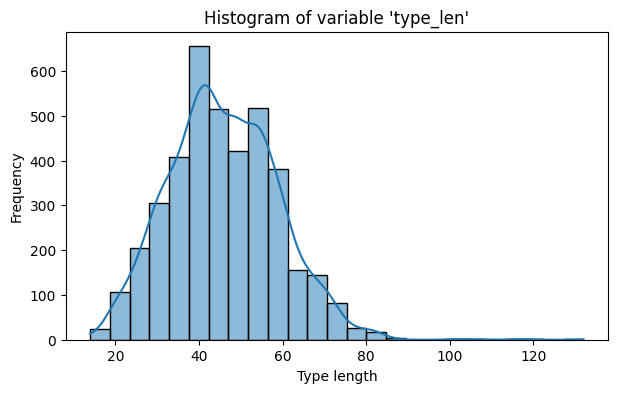

In [12]:
# Calculate new variable 'type_len' with length of strings in 'type', use .appy()
df['type_len'] = df['type'].apply(len)

# Display variables 'type' and 'type_len'
df[['type', 'type_len']].head()

# Plot histogram of variable 'type_len'
plt.figure(figsize=(7, 4))
sns.histplot(df['type_len'], bins=25, kde=True)
plt.title("Histogram of variable 'type_len'")
plt.xlabel('Type length')
plt.ylabel('Frequency')
plt.show()


### Create binary (0/1) variable 'luxury_car'

In [13]:
# Create a pattern which can be used to search the variable 'type'
pattern = 'BUGATTI|FERRARI|ROLLS-ROYCE|LAMBORGHINI|BENTLEY|ASTON MARTIN|MASERATI|MCLAREN|PORSCHE'

# Create new variable 'luxury_car' as binary dummy (0/1) variable
df['luxury_car'] = df['type'].str.contains(pat = pattern).astype(int)
print(df['luxury_car'].sum())

# Show values
df[['type','luxury_car',]].loc[df['luxury_car'] == 1]

299


,type,luxury_car
8,PORSCHE 911 TURBO CABRIO PDK (CABRIOLET),1
26,FERRARI 348 TS (CABRIOLET),1
57,PORSCHE 911 SC (COUPÉ),1
64,PORSCHE 911 CARRERA 4S PDK (COUPÉ),1
65,PORSCHE 911 CARRERA 4S CABRIO (CABRIOLET),1
...,...,...
3933,FERRARI 458 ITALIA 4.5 V8 (COUPÉ),1
3934,FERRARI 458 ITALIA 4.5 V8 (COUPÉ),1
3958,PORSCHE 911 TURBO (S) CABRIO (CABRIOLET),1
3964,BENTLEY ARNAGE RED LABEL (LIMOUSINE),1


### Create variable 'price_per_hp'

In [14]:
# Create variable 'price_per_hp' (round to 2 decimal places)
df['price_per_hp'] = round(df['price'] / df['hp'], 2)

# Display variables 'price', 'hp' and 'price_per_hp'
df[['price', 'hp', 'price_per_hp']].head()


,price,hp,price_per_hp
0,22500,245,91.84
1,23749,184,129.07
2,18500,306,60.46
3,36000,360,100.0
4,48500,252,192.46


### Include current datetime as time stamp

In [15]:
# Include current datetime as time stamp in the format 'YYYY-MM-DD HH:MM:SS'
df['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df['timestamp'].head()

0    2025-11-03 12:11:02
1    2025-11-03 12:11:02
2    2025-11-03 12:11:02
3    2025-11-03 12:11:02
4    2025-11-03 12:11:02
Name: timestamp, dtype: object

## Discretization of numerical data

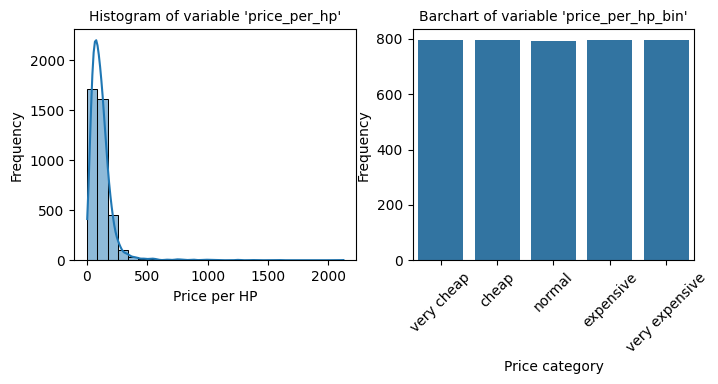

,price_per_hp,price_per_hp_bin
0,91.84,normal
1,129.07,expensive
2,60.46,cheap
3,100.0,normal
4,192.46,very expensive


In [16]:
# Discretization of the variable 'price_per_hp' into 5 bins (note the 'qcut' function)
df['price_per_hp_bin'] = pd.qcut(df['price_per_hp'], 
                                 q=5,  # number of quantiles
                                 labels=['very cheap', 
                                         'cheap', 
                                         'normal', 
                                         'expensive', 
                                         'very expensive'])

# Show histogram of price_per_hp and barchart of variable 'price_per_hp_bin'
plt.figure(figsize=(8, 3))

# Create a 1x2 grid
plt.subplot(1, 2, 1)
sns.histplot(df['price_per_hp'], bins=25, kde=True)
plt.title("Histogram of variable 'price_per_hp'", fontsize=10)
plt.xlabel('Price per HP')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='price_per_hp_bin', orient='v')
plt.title("Barchart of variable 'price_per_hp_bin'", fontsize=10)
plt.xlabel('Price category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Display variables 'price_per_hp' and 'price_per_hp_bin'
df[['price_per_hp', 'price_per_hp_bin']].head()



## One Hot Encoding

In [17]:
# One Hot Encoding of the variable 'price_per_m2_cat'
try:
    df = pd.get_dummies(df, 
                        columns=['price_per_hp_bin'], 
                        drop_first=False)
except:
    print("Dummy variables already exist")

# Convert boolean values to integers (0 and 1)
df[df.filter(like='price_per_hp_bin').columns] = df.filter(like='price_per_hp_bin').astype(int)

# Show values of the new dummy variables
df.filter(like='price_per_hp_bin').head()


,price_per_hp_bin_very cheap,price_per_hp_bin_cheap,price_per_hp_bin_normal,price_per_hp_bin_expensive,price_per_hp_bin_very expensive
0,0,0,1,0,0
1,0,0,0,1,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,0,1


## Scaling

### Min-Max Scaling

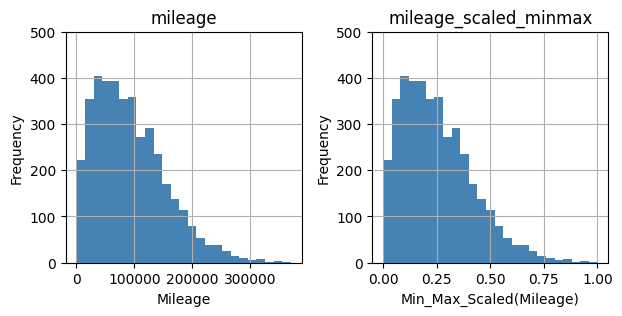

In [18]:
# Min-Max scaling of the variable 'mileage'
df['mileage_scaled_minmax'] = (df['mileage'] - df['mileage'].min()) / (df['mileage'].max() - df['mileage'].min())

# Histogram of the variable 'area' and 'area_scaled'
ax = df[['mileage', 'mileage_scaled_minmax']].hist(bins=25, 
                                      figsize=(7, 3), 
                                      color='steelblue')
                                      
# Set the y-axis range for each subplot and add labels
for axis, label in zip(ax.flatten(), ['Mileage', 'Min_Max_Scaled(Mileage)']):
    axis.set_ylim(0, 500)
    axis.set_xlabel(label)
    axis.set_ylabel('Frequency')

# Display the plot
plt.show()

### Max-Absolute Scaling

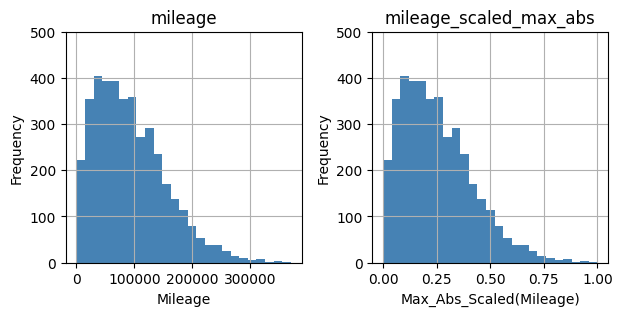

In [19]:
# Max-Absolute scaling of the variable 'area'
df['mileage_scaled_max_abs'] = df['mileage'] / df['mileage'].abs().max()

# Histogram of the variable 'area' and 'area_scaled_max_abs'
ax = df[['mileage', 'mileage_scaled_max_abs']].hist(bins=25, 
                                              figsize=(7, 3), 
                                              color='steelblue')

# Set the y-axis range for each subplot and add labels
for axis, label in zip(ax.flatten(), ['Mileage', 'Max_Abs_Scaled(Mileage)']):
    axis.set_ylim(0, 500)
    axis.set_xlabel(label)
    axis.set_ylabel('Frequency')

# Display the plot
plt.show()

### Robust Scaling

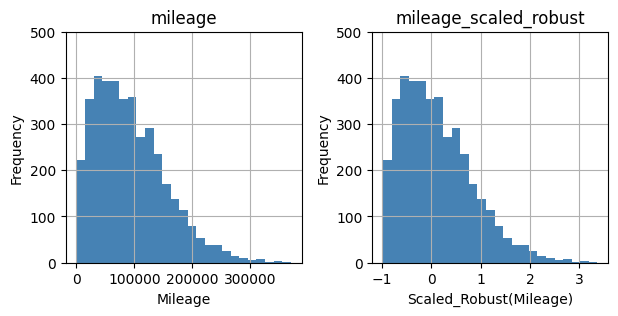

In [20]:
# Robust scaling of the variable 'area'
df['mileage_scaled_robust'] = (df['mileage'] - df['mileage'].median()) / \
                           (df['mileage'].quantile(0.75) \
                           - df['mileage'].quantile(0.25))

# Histogram of the variable 'area' and 'area_scaled_robust'
ax = df[['mileage', 'mileage_scaled_robust']].hist(bins=25, 
                                             figsize=(7, 3), 
                                             color='steelblue')

# Set the y-axis range for each subplot and add labels
for axis, label in zip(ax.flatten(), ['Mileage', 'Scaled_Robust(Mileage)']):
    axis.set_ylim(0, 500)
    axis.set_xlabel(label)
    axis.set_ylabel('Frequency')

# Display the plot
plt.show()

## Standardization

### Z-score Normalization

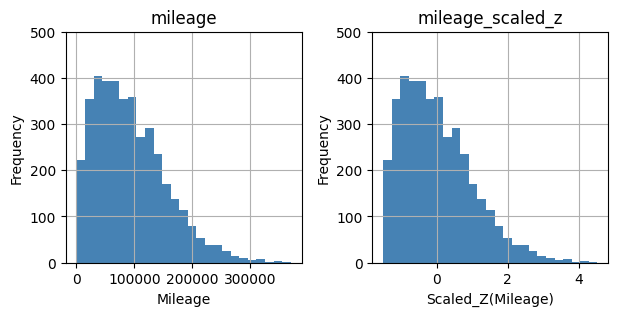

In [21]:
# Z-score Normalization of the variable 'area'
df['mileage_scaled_z'] = (df['mileage'] - df['mileage'].mean()) / df['mileage'].std()

# Histogram of the variable 'area' and 'area_scaled_z'
ax = df[['mileage', 'mileage_scaled_z']].hist(bins=25, 
                                        figsize=(7, 3), 
                                        color='steelblue')

# Set the y-axis range for each subplot and add labels
for axis, label in zip(ax.flatten(), ['Mileage', 'Scaled_Z(Mileage)']):
    axis.set_ylim(0, 500)
    axis.set_xlabel(label)
    axis.set_ylabel('Frequency')

# Display the plot
plt.show()

## Transformation

### Log-Transformation

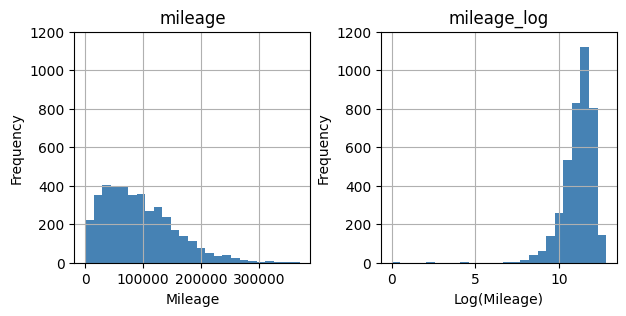

In [22]:
# Log-Transformation of the variable 'area'
df['mileage_log'] = np.log(df['mileage'])

# Histogram of the variable 'area' and 'area_log'
ax = df[['mileage', 'mileage_log']].hist(bins=25, 
                                   figsize=(7, 3), 
                                   color='steelblue')

# Set the y-axis range for each subplot and add labels
for axis, label in zip(ax.flatten(), ['Mileage', 'Log(Mileage)']):
    axis.set_ylim(0, 1200)
    axis.set_xlabel(label)
    axis.set_ylabel('Frequency')

# Display the plot
plt.show()

### SQRT-Transformation

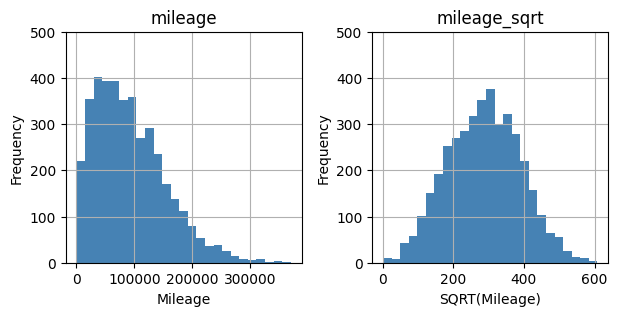

In [23]:
# SQRT-Transformation of the variable 'area'
df['mileage_sqrt'] = np.sqrt(df['mileage'])

# Histogram of the variable 'area' and 'area_sqrt'
ax = df[['mileage', 'mileage_sqrt']].hist(bins=25, 
                                    figsize=(7, 3), 
                                    color='steelblue')

# Set the y-axis range for each subplot and add labels
for axis, label in zip(ax.flatten(), ['Mileage', 'SQRT(Mileage)']):
    axis.set_ylim(0, 500)
    axis.set_xlabel(label)
    axis.set_ylabel('Frequency')

# Display the plot
plt.show()

### Box-Cox Transformation

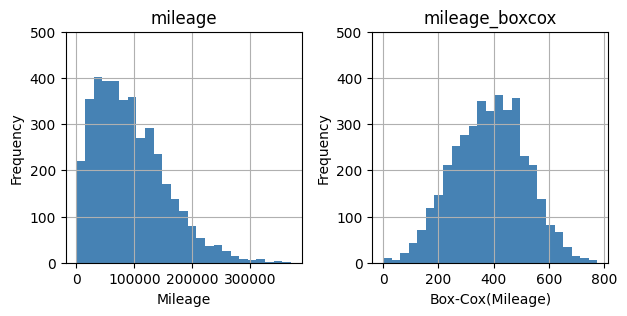

In [24]:
# Box-Cox Transformation of the variable 'area'
from scipy.stats import boxcox

# Apply Box-Cox transformation
df['mileage_boxcox'], _ = boxcox(df['mileage'])

# Histogram of the variable 'area' and 'area_boxcox'
ax = df[['mileage', 'mileage_boxcox']].hist(bins=25, 
                                      figsize=(7, 3), 
                                      color='steelblue')

# Set the y-axis range for each subplot and add labels
for axis, label in zip(ax.flatten(), ['Mileage', 'Box-Cox(Mileage)']):
    axis.set_ylim(0, 500)
    axis.set_xlabel(label)
    axis.set_ylabel('Frequency')

# Display the plot
plt.show()

## Combining & organizing data

### Reading car data with geocoded addresses

In [25]:
# Meaning of variables
# offer_id: unique identifier of the offer on autoscout24.ch
# lat: geographical latitude
# lon: geographical longitude
# bfs_number: official municipality id
# bfs_name: official municipality name

# Geocoded data (i.e. data with latitude and longitude)
df_geo = pd.read_csv('./Data/autoscout24_data_geocoded.csv', 
                     sep=';', 
                     encoding='utf-8')

# Show data
df_geo.head()

,offer_id,lat,lon,bfs_number,bfs_name
0,7324420,47.434376,8.859333,228,Turbenthal
1,7512768,46.850327,7.200491,2293,Düdingen
2,7512034,46.386593,6.204862,5716,Eysins
3,7512728,47.542408,7.873130,4263,Zeiningen
4,7490242,47.067474,7.302120,306,Lyss


### Join geo-information to car data using .merge()

In [26]:
df2 = df.merge(df_geo[['offer_id', 
                       'lat', 
                       'lon', 
                       'bfs_number', 
                       'bfs_name']], 
               on="offer_id",)

# Show data
df2[['offer_id',
     'type',	
     'price',
     'hp',
     'price_per_hp',
     'mileage',	
     'fuel_type',	
     'lat', 
     'lon', 
     'bfs_number', 
     'bfs_name']].head()

,offer_id,type,price,hp,price_per_hp,mileage,fuel_type,lat,lon,bfs_number,bfs_name
0,7324420,AUDI A5 SPORTBACK 3.0 TDI QUATTRO S-TRONIC (LI...,22500,245,91.84,75000,Diesel,47.434376,8.859333,228,Turbenthal
1,7512768,MERCEDES-BENZ SLK 200 7G-TRONIC (CABRIOLET),23749,184,129.07,46655,Benzin,46.850327,7.200491,2293,Düdingen
2,7512034,MERCEDES-BENZ C 350 AVANTGARDE 4MATIC 7G-TRONI...,18500,306,60.46,138955,Benzin,46.386593,6.204862,5716,Eysins
3,7512728,MERCEDES-BENZ A 45 AMG 4MATIC SPEEDSHIFT 7G-DC...,36000,360,100.0,43000,Benzin,47.542408,7.873130,4263,Zeiningen
4,7490242,AUDI A5 SPORTBACK 2.0 TFSI SPORT QUATTRO S-TRO...,48500,252,192.46,43300,Benzin,47.067474,7.302120,306,Lyss


### Reading municipality-level data from an .xlsx - file

In [27]:
# Meaning of variables:
# bfs_number: municipality id
# bfs_name: municipality name
# pop: number of residents
# pop_dens: population density per km2
# frg_pct: percentage foreigners
# emp: number of employees

df_municip = pd.read_excel('./Data/municipality_data.xlsx', 
                           sheet_name='data_for_import')
df_municip.head(5)

,bfs_number,bfs_name,pop,pop_dens,frg_pct,emp
0,1,Aeugst am Albis,1981,250.442478,14.184755,442.0
1,2,Affoltern am Albis,12303,1161.756374,28.700317,6920.0
2,3,Bonstetten,5572,749.932705,16.564968,1014.0
3,4,Hausen am Albis,3751,275.808824,16.022394,1021.0
4,5,Hedingen,3778,578.560490,16.410799,1478.0


### Join municipality-level data to the car data data using .merge()

In [28]:
# Merge needs a key which must be identical in both data sets (here the key is 'bfs_number')
df3 = df2.merge(df_municip[['bfs_number', 
                            'pop', 
                            'pop_dens', 
                            'frg_pct', 
                            'emp']], 
                on="bfs_number")

# Show data
df3[['offer_id',
     'type',
     'price',
     'mileage',
     'hp',
     'price_per_hp',
     'fuel_type',
     'lat', 
     'lon', 
     'bfs_number', 
     'bfs_name',
     'pop',	
     'pop_dens']].head()

,offer_id,type,price,mileage,hp,price_per_hp,fuel_type,lat,lon,bfs_number,bfs_name,pop,pop_dens
0,7324420,AUDI A5 SPORTBACK 3.0 TDI QUATTRO S-TRONIC (LI...,22500,75000,245,91.84,Diesel,47.434376,8.859333,228,Turbenthal,4883,193.616178
1,7512768,MERCEDES-BENZ SLK 200 7G-TRONIC (CABRIOLET),23749,46655,184,129.07,Benzin,46.850327,7.200491,2293,Düdingen,8181,265.962289
2,7512034,MERCEDES-BENZ C 350 AVANTGARDE 4MATIC 7G-TRONI...,18500,138955,306,60.46,Benzin,46.386593,6.204862,5716,Eysins,1735,728.991597
3,7512728,MERCEDES-BENZ A 45 AMG 4MATIC SPEEDSHIFT 7G-DC...,36000,43000,360,100.0,Benzin,47.542408,7.873130,4263,Zeiningen,2381,209.410730
4,7490242,AUDI A5 SPORTBACK 2.0 TFSI SPORT QUATTRO S-TRO...,48500,43300,252,192.46,Benzin,47.067474,7.302120,306,Lyss,15525,1046.864464


### Sorting data

In [29]:
# Sorting data by 'price' and 'area' with highest price above (ascending=False)
df3 = df3.sort_values(by=['price', 'mileage'], 
                ascending=False)

df3[['offer_id',
     'type',
     'price',
     'mileage',
     'hp',
     'price_per_hp',
     'fuel_type',
     'lat', 
     'lon', 
     'bfs_number', 
     'bfs_name',
     'pop',	
     'pop_dens']].head()


,offer_id,type,price,mileage,hp,price_per_hp,fuel_type,lat,lon,bfs_number,bfs_name,pop,pop_dens
1434,6395032,PORSCHE 911 GT2 RS (COUPÉ),428000,8900,620,690.32,Benzin,46.618042,7.024349,2160,Vuadens,2435,233.014354
274,6978696,LAMBORGHINI AVENTADOR S LP740-4 ROADSTER E-GEA...,384900,4000,741,519.43,Benzin,47.354149,8.560637,261,Zürich,420217,4778.994655
2400,7448261,PORSCHE 911 SPEEDSTER MANUAL GEARBOX CHALK WHI...,379000,14,510,743.14,Benzin,46.533829,6.611891,5586,Lausanne,139408,3368.970517
3424,6768872,MCLAREN 675LT COUPÉ 3.8 V8 SSG (COUPÉ),280000,11500,675,414.81,Benzin,46.220200,6.145626,6621,Genève,203951,12810.992462
1612,5887777,MERCEDES-BENZ 220 SE (CABRIOLET),255000,1200,120,2125.0,Benzin,46.992401,8.310424,1507,Hergiswil (NW),5776,403.916084


### Reshaping data

#### Reshaping data using .stack() and .unstack()

In [30]:
df_sub = df3[['bfs_name', 'mileage', 'price', 'hp']][:5]
print('Original shape')
print(df_sub, '\n')

df_sub_stacked = df_sub.stack()
print('Stacked')
print(df_sub_stacked, '\n')

# Using unstack
print('Unstacked (= back to original shape)')
print(df_sub_stacked.unstack())

Original shape
            bfs_name  mileage   price   hp
1434         Vuadens     8900  428000  620
274           Zürich     4000  384900  741
2400        Lausanne       14  379000  510
3424          Genève    11500  280000  675
1612  Hergiswil (NW)     1200  255000  120 

Stacked
1434  bfs_name           Vuadens
      mileage               8900
      price               428000
      hp                     620
274   bfs_name            Zürich
      mileage               4000
      price               384900
      hp                     741
2400  bfs_name          Lausanne
      mileage                 14
      price               379000
      hp                     510
3424  bfs_name            Genève
      mileage              11500
      price               280000
      hp                     675
1612  bfs_name    Hergiswil (NW)
      mileage               1200
      price               255000
      hp                     120
dtype: object 

Unstacked (= back to original shape)
    

#### Reshaping data using .melt()

In [31]:
df_sub = df3[['mileage', 'price', 'hp']][:5]
print('Original shape')
print(df_sub, '\n')

print('Reshaped using .melt()')
print(pd.melt(df, id_vars=['mileage'], value_vars=['price', 'hp']))

Original shape
      mileage   price   hp
1434     8900  428000  620
274      4000  384900  741
2400       14  379000  510
3424    11500  280000  675
1612     1200  255000  120 

Reshaped using .melt()
      mileage variable  value
0       75000    price  22500
1       46655    price  23749
2      138955    price  18500
3       43000    price  36000
4       43300    price  48500
...       ...      ...    ...
7937    78000       hp    400
7938   315000       hp    232
7939    85000       hp    525
7940   188920       hp    193
7941   134000       hp    193

[7942 rows x 3 columns]


### Pivoting data using .pivot_table()

In [32]:
pivot_table = pd.pivot_table(df3[['mileage', 'price', 'price_per_hp', 'hp', 'fuel_type']],
                             index=['fuel_type'],
                             values={'price': np.mean, 
                                     'price_per_hp': np.mean, 
                                     'hp': np.mean,
                                     'mileage': np.mean}).round(2)

# Format the values to 2 decimal places with trailing zeros
pivot_table = pivot_table.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

# Display the pivot table
pivot_table

,hp,mileage,price,price_per_hp
fuel_type,,,,
Automat,304.00,76000.00,49000.00,161.18
Automatik-Getriebe,258.00,37800.00,79999.00,310.07
Benzin,245.38,89881.89,27344.08,112.76
Diesel,198.24,103766.03,24888.95,123.83
Elektro,457.79,59694.98,53093.18,138.80
Erdgas (CNG) / Benzin,85.00,50561.00,5900.00,69.41
Flüssiggas (LPG) / Benzin,97.00,83000.00,4800.00,49.48
Hybrid Benzin/Elektro,339.00,128356.00,19900.00,58.70
Hybrid Diesel/Elektro,261.00,263209.00,34000.00,130.27


### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [33]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.8.0-1030-azure
Datetime: 2025-11-03 12:11:05
Python Version: 3.11.14
-----------------------------------
